# [In progress] Optimizing a parameterized quantum circuit: Gradient-descent, JAX backend for DensityMatrix

Variational circuits are a class of circuits which are composed of continuously parameterized gates. These parameters are generally optimized to meet a certain functionality, such as generating a target output quantum state. Such variational circuits are attractive in the NISQ era, where quantum devices are not error-corrected and limited to shallow (i.e., few-gate) circuits.

We use `JAX` and its ecosystem of associated libraries, such as `Optax`, for automatically differentiation our circuits and optimizing them via a gradient descent algorithm.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# to use differentiation, we must set the array library to 'jax' at the top of the script 
import src
src.DENSITY_MATRIX_ARRAY_LIBRARY = "jax"

import optax
import jax

In [3]:
import matplotlib.pyplot as plt
import tqdm

from src import ops
from src.circuit import CircuitDAG
import src.backends.density_matrix.functions as dmf
from src.backends.density_matrix.compiler import DensityMatrixCompiler
from src.metrics import Infidelity

import benchmarks.circuits

c:\venvs\graph-compiler\lib\site-packages\jax\_src\scipy\linalg.py
c:\venvs\graph-compiler\lib\site-packages\jax\numpy\__init__.py


As usual, we start with our target state. For this tutorial, choose any of the Bell state, 3- or 4-qubit GHZ state. We will use the infidelity as our metric to minimize. Currently, variational circuits are only supported for the DensityMatrix backend.

In [4]:
_, target = benchmarks.circuits.bell_state_circuit()
# _, target = benchmarks.circuits.ghz3_state_circuit()
# _, target = benchmarks.circuits.ghz4_state_circuit()

compiler = DensityMatrixCompiler()
metric = Infidelity(target=target)

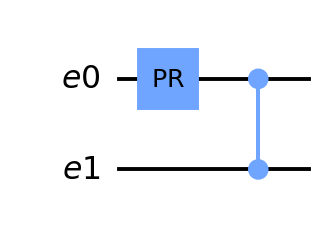

In [5]:
circuit = CircuitDAG(n_emitter=target.n_qubits, n_photon=0, n_classical=0)

circuit.add(
    ops.ParameterizedOneQubitRotation(
        register=0,
        reg_type="e",
        params=(0.0, 1.0, 1.0),  # set the parameters explicitly, if desired
    )
)
for i in range(1, target.n_qubits):
    circuit.add(
        ops.ParameterizedControlledRotationQubit(
            control=i - 1, control_type="e", target=i, target_type="e"
        )
    )

circuit.draw_circuit()

params = circuit.initialize_parameters()  # randomly sample the initial parameters

We wrap all the functions for computing the metric loss value into a single function, where the first parameter is our parameter dictionary.

In [6]:
def compute_loss(params: dict, circuit: CircuitDAG):
    circuit.parameters = params
    output_state = compiler.compile(circuit)
    loss = metric.evaluate(output_state, circuit)
    return loss


compute_loss(params, circuit)

DeviceArray(0.51202965, dtype=float32)

Now, we define our `Optax` optimizer to use. For this demonstration, we will use the Adagrad algorithm, but many other popular optimizers exist and are already implemented in `Optax`. These include Adam, SGD, RMSProp, etc.

In [7]:
learning_rate = 0.4
n_step = 100
progress = True
optimizer = optax.adagrad(learning_rate)
opt_state = optimizer.init(params)

Here is the main learning loop. We iterate `n_step` times in our gradient-descent algorithm. Each loss value is stored to an array for plotting the learning curve later.

In [8]:
loss_curve = []
for step in (pbar := tqdm.tqdm(range(n_step), disable=(not progress))):
    loss = compute_loss(params, circuit)
    grads = jax.grad(compute_loss)(params, circuit)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    loss_curve.append(loss)
    if progress:
        pbar.set_description(f"Cost: {loss:.10f}")
    else:
        print(step, loss, params)

Cost: 0.0000000000: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


Plot the resulting state to see how the optimization performed.

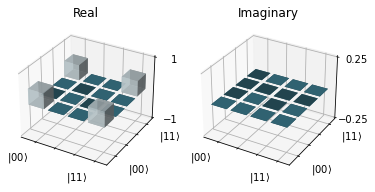

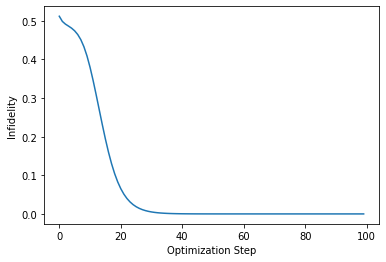

In [9]:
circuit.parameters = params
output_state = compiler.compile(circuit)
output_state.dm.draw()

fig, ax = plt.subplots(1, 1)
ax.plot(loss_curve)
ax.set(xlabel="Optimization Step", ylabel="Infidelity")
plt.show()

Now we do it with the GradientDescentSolver.

In [10]:
from src.solvers.gradient_descent_solver import GradientDescentSolver, adagrad

In [11]:
optimizer = adagrad(learning_rate=0.4)
solver = GradientDescentSolver(
    target=target,
    metric=metric,
    compiler=compiler,
    circuit=circuit,
    optimizer=optimizer,
    n_step=n_step,
)

In [12]:
loss_curve, params = solver.solve()

Cost: 0.0000000596: 100%|██████████| 100/100 [00:13<00:00,  7.48it/s]


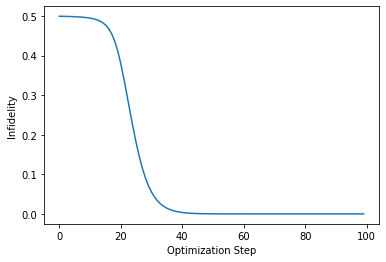

In [13]:
fig, ax = plt.subplots(1, 1)
ax.plot(loss_curve)
ax.set(xlabel="Optimization Step", ylabel="Infidelity")
plt.show()